In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
transform = transforms.ToTensor()

#transform = transforms.Compose([
#    transforms.ToTensor(),
#    transforms.Normalize((0.5), (0.5))
#])

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=64,
                                          shuffle=True)

In [4]:
dataiter = iter(data_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [5]:
class Autoencoder_Linear(nn.Module):
    def __init__(self):
        # N(batch size), 784(number of pixels)
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),   # N, 784 -> N, 128
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3) # -> N, 3
        )

        self.decoder = nn.Sequential(
            nn.Linear(3, 12),   
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid() # N, 3 -> N, 784
        )


    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Note : [-1, 1] -> nn.Tahn

In [ ]:
class Autoencoder_Cnn(nn.Module):
    def __init__(self):
        # N, 1, 28, 28
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),   # N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # N, 64, 1, 1 
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),  # N, 32, 7, 7 
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # N, 16, 14, 14 
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28
            nn.Sigmoid() 
        )


    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Note nn.MaxPool2d -> nn.MaxUnpool2d

In [8]:
model = Autoencoder_Cnn()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay=1e-5)

In [9]:
# Trainning Loop
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        recon = model(img)  #Reconstructed image
        loss = criterion(recon, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0096
Epoch:2, Loss:0.0059
Epoch:3, Loss:0.0040
Epoch:4, Loss:0.0034
Epoch:5, Loss:0.0035
Epoch:6, Loss:0.0033
Epoch:7, Loss:0.0034
Epoch:8, Loss:0.0031
Epoch:9, Loss:0.0029
Epoch:10, Loss:0.0028


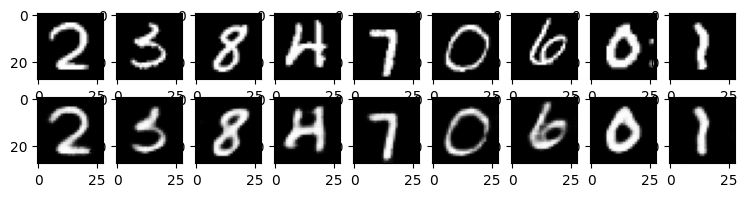

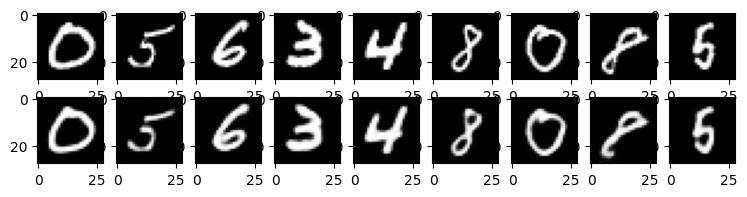

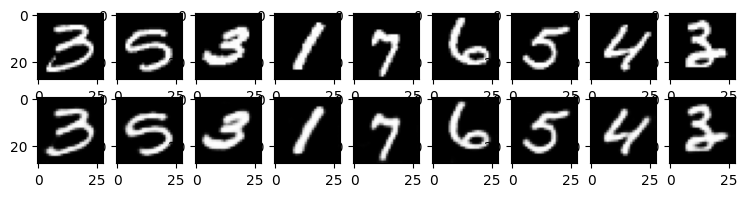

In [10]:
# Plotting Images
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        # item: 1, 28, 28
        plt.imshow(item[0])
    
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) #row_length + i + 1
        item = item.reshape(-1, 28, 28)
        # item: 1, 28, 28
        plt.imshow(item[0])